Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [2]:
%cd ..

/home/anuar/PycharmProjects/master-thesis


In [3]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [4]:
start_time='2020-02-26'
end_time='2020-09-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [5]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


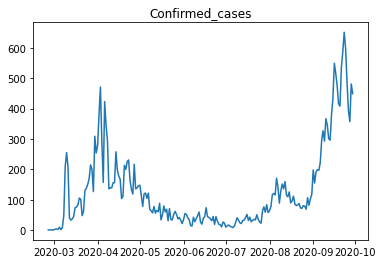

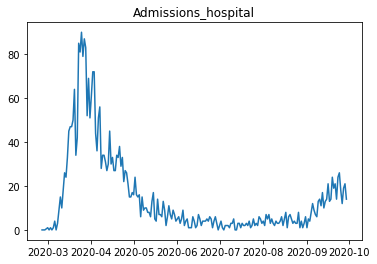

In [6]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [7]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [8]:
method = RandomWalk(num_observations,device,dtype)

## Initialize alpha and phi TODO

In [10]:
alpha = 0.01

# Optimization

## Training

Step: 0, Time: 0.20406651496887207, Loss: 18971756.0, Mean Expected Daily Hospit: 1696.43310546875


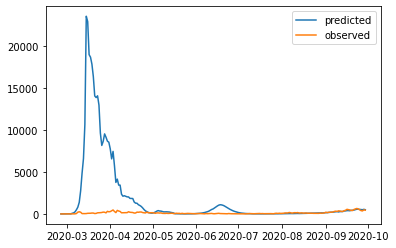

Step: 5, Time: 0.1679375171661377, Loss: 10399946.0, Mean Expected Daily Hospit: 1230.8868408203125
Step: 10, Time: 0.16228699684143066, Loss: 6063730.5, Mean Expected Daily Hospit: 931.9713745117188
Step: 15, Time: 0.1607799530029297, Loss: 3838554.5, Mean Expected Daily Hospit: 741.4102172851562
Step: 20, Time: 0.14204907417297363, Loss: 2638536.0, Mean Expected Daily Hospit: 618.5121459960938
Step: 25, Time: 0.14980411529541016, Loss: 1949393.875, Mean Expected Daily Hospit: 536.47705078125
Step: 30, Time: 0.1391465663909912, Loss: 1527601.125, Mean Expected Daily Hospit: 479.5568542480469
Step: 35, Time: 0.14703035354614258, Loss: 1253549.75, Mean Expected Daily Hospit: 438.7201232910156
Step: 40, Time: 0.14713191986083984, Loss: 1065516.125, Mean Expected Daily Hospit: 408.4548034667969
Step: 45, Time: 0.14223027229309082, Loss: 930000.25, Mean Expected Daily Hospit: 385.2698974609375
Step: 50, Time: 0.13642501831054688, Loss: 827959.4375, Mean Expected Daily Hospit: 366.874298095

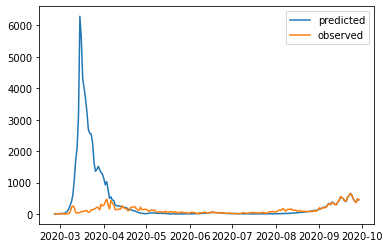

Step: 55, Time: 0.14111661911010742, Loss: 748119.5625, Mean Expected Daily Hospit: 351.7646789550781
Step: 60, Time: 0.12984800338745117, Loss: 683568.25, Mean Expected Daily Hospit: 338.9955749511719
Step: 65, Time: 0.14146780967712402, Loss: 629925.8125, Mean Expected Daily Hospit: 327.9868469238281
Step: 70, Time: 0.1288442611694336, Loss: 584340.125, Mean Expected Daily Hospit: 318.36505126953125
Step: 75, Time: 0.14735960960388184, Loss: 544898.9375, Mean Expected Daily Hospit: 309.8464660644531
Step: 80, Time: 0.16988062858581543, Loss: 510282.96875, Mean Expected Daily Hospit: 302.1961669921875
Step: 85, Time: 0.1541728973388672, Loss: 479555.21875, Mean Expected Daily Hospit: 295.2344055175781
Step: 90, Time: 0.1339414119720459, Loss: 452033.40625, Mean Expected Daily Hospit: 288.84710693359375
Step: 95, Time: 0.13180065155029297, Loss: 427203.125, Mean Expected Daily Hospit: 282.96142578125
Step: 100, Time: 0.13531899452209473, Loss: 404668.21875, Mean Expected Daily Hospit: 

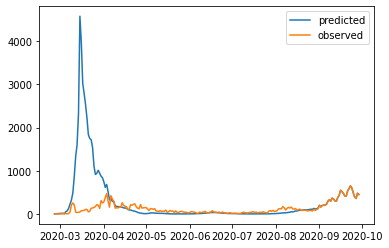

Step: 105, Time: 0.14310979843139648, Loss: 384115.96875, Mean Expected Daily Hospit: 272.4632568359375
Step: 110, Time: 0.12785792350769043, Loss: 365293.28125, Mean Expected Daily Hospit: 267.7480773925781
Step: 115, Time: 0.129591703414917, Loss: 347992.8125, Mean Expected Daily Hospit: 263.3385009765625
Step: 120, Time: 0.12841534614562988, Loss: 332039.9375, Mean Expected Daily Hospit: 259.2093811035156
Step: 125, Time: 0.12845063209533691, Loss: 317289.625, Mean Expected Daily Hospit: 255.33546447753906
Step: 130, Time: 0.13744544982910156, Loss: 303614.84375, Mean Expected Daily Hospit: 251.68789672851562
Step: 135, Time: 0.15171575546264648, Loss: 290908.0625, Mean Expected Daily Hospit: 248.2384796142578
Step: 140, Time: 0.18459439277648926, Loss: 279075.84375, Mean Expected Daily Hospit: 244.9635467529297
Step: 145, Time: 0.14536595344543457, Loss: 268035.15625, Mean Expected Daily Hospit: 241.84007263183594
Step: 150, Time: 0.13586640357971191, Loss: 257714.734375, Mean Expe

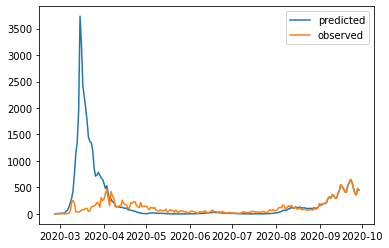

Step: 155, Time: 0.1415400505065918, Loss: 248050.28125, Mean Expected Daily Hospit: 235.98492431640625
Step: 160, Time: 0.1455984115600586, Loss: 238985.203125, Mean Expected Daily Hospit: 233.22581481933594
Step: 165, Time: 0.17249703407287598, Loss: 230469.09375, Mean Expected Daily Hospit: 230.56700134277344
Step: 170, Time: 0.09800410270690918, Loss: 222456.625, Mean Expected Daily Hospit: 227.99978637695312
Step: 175, Time: 0.07643556594848633, Loss: 214907.5625, Mean Expected Daily Hospit: 225.51971435546875
Step: 180, Time: 0.07147717475891113, Loss: 207785.3125, Mean Expected Daily Hospit: 223.12403869628906
Step: 185, Time: 0.07410669326782227, Loss: 201056.703125, Mean Expected Daily Hospit: 220.80801391601562
Step: 190, Time: 0.07753252983093262, Loss: 194692.3125, Mean Expected Daily Hospit: 218.56834411621094
Step: 195, Time: 0.0766441822052002, Loss: 188664.6875, Mean Expected Daily Hospit: 216.40443420410156
Step: 200, Time: 0.07137680053710938, Loss: 182950.078125, Mea

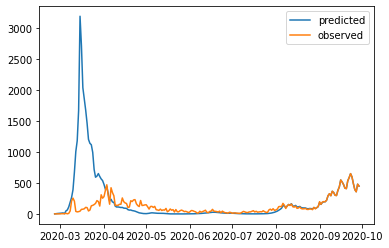

Step: 205, Time: 0.07564663887023926, Loss: 177525.875, Mean Expected Daily Hospit: 212.2893829345703
Step: 210, Time: 0.07404756546020508, Loss: 172371.265625, Mean Expected Daily Hospit: 210.33274841308594
Step: 215, Time: 0.08290672302246094, Loss: 167468.625, Mean Expected Daily Hospit: 208.44000244140625
Step: 220, Time: 0.07445836067199707, Loss: 162800.40625, Mean Expected Daily Hospit: 206.60589599609375
Step: 225, Time: 0.07663083076477051, Loss: 158351.4375, Mean Expected Daily Hospit: 204.83297729492188
Step: 230, Time: 0.0755457878112793, Loss: 154107.34375, Mean Expected Daily Hospit: 203.11465454101562
Step: 235, Time: 0.07414627075195312, Loss: 150055.1875, Mean Expected Daily Hospit: 201.44979858398438
Step: 240, Time: 0.08068585395812988, Loss: 146182.9375, Mean Expected Daily Hospit: 199.84011840820312
Step: 245, Time: 0.07589554786682129, Loss: 142479.546875, Mean Expected Daily Hospit: 198.27769470214844
Step: 250, Time: 0.07989788055419922, Loss: 138934.8125, Mean 

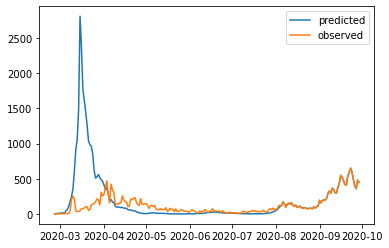

Step: 255, Time: 0.07490372657775879, Loss: 135539.328125, Mean Expected Daily Hospit: 195.29661560058594
Step: 260, Time: 0.07003164291381836, Loss: 132284.578125, Mean Expected Daily Hospit: 193.8717041015625
Step: 265, Time: 0.10139870643615723, Loss: 129162.2109375, Mean Expected Daily Hospit: 192.49026489257812
Step: 270, Time: 0.07498550415039062, Loss: 126165.1640625, Mean Expected Daily Hospit: 191.14785766601562
Step: 275, Time: 0.10788249969482422, Loss: 123286.25, Mean Expected Daily Hospit: 189.84503173828125
Step: 280, Time: 0.09485125541687012, Loss: 120519.0546875, Mean Expected Daily Hospit: 188.57701110839844
Step: 285, Time: 0.07384347915649414, Loss: 117857.4921875, Mean Expected Daily Hospit: 187.34567260742188
Step: 290, Time: 0.07372784614562988, Loss: 115296.1875, Mean Expected Daily Hospit: 186.14720153808594
Step: 295, Time: 0.07706379890441895, Loss: 112829.8359375, Mean Expected Daily Hospit: 184.9820098876953
Step: 300, Time: 0.07608962059020996, Loss: 11045

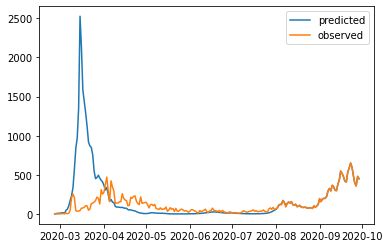

Step: 305, Time: 0.0722646713256836, Loss: 108162.6171875, Mean Expected Daily Hospit: 182.7414093017578
Step: 310, Time: 0.07085824012756348, Loss: 105953.2109375, Mean Expected Daily Hospit: 181.66619873046875
Step: 315, Time: 0.08111906051635742, Loss: 103820.9453125, Mean Expected Daily Hospit: 180.6171875
Step: 320, Time: 0.10801362991333008, Loss: 101762.1640625, Mean Expected Daily Hospit: 179.59547424316406
Step: 325, Time: 0.09170770645141602, Loss: 99773.4765625, Mean Expected Daily Hospit: 178.59808349609375
Step: 330, Time: 0.07613658905029297, Loss: 97851.5234375, Mean Expected Daily Hospit: 177.62713623046875
Step: 335, Time: 0.10434293746948242, Loss: 95993.046875, Mean Expected Daily Hospit: 176.68011474609375
Step: 340, Time: 0.0794365406036377, Loss: 94195.4140625, Mean Expected Daily Hospit: 175.7545928955078
Step: 345, Time: 0.0810399055480957, Loss: 92455.734375, Mean Expected Daily Hospit: 174.8526153564453
Step: 350, Time: 0.08305048942565918, Loss: 90771.3671875

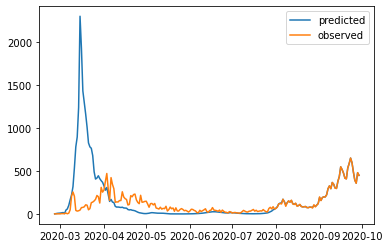

Step: 355, Time: 0.08260703086853027, Loss: 89139.9296875, Mean Expected Daily Hospit: 173.11216735839844
Step: 360, Time: 0.08154177665710449, Loss: 87559.1640625, Mean Expected Daily Hospit: 172.27330017089844
Step: 365, Time: 0.08475232124328613, Loss: 86026.75, Mean Expected Daily Hospit: 171.45310974121094
Step: 370, Time: 0.07513928413391113, Loss: 84540.78125, Mean Expected Daily Hospit: 170.65176391601562
Step: 375, Time: 0.08076715469360352, Loss: 83099.2265625, Mean Expected Daily Hospit: 169.8672637939453
Step: 380, Time: 0.08094477653503418, Loss: 81700.3125, Mean Expected Daily Hospit: 169.1022186279297
Step: 385, Time: 0.08316612243652344, Loss: 80342.109375, Mean Expected Daily Hospit: 168.35528564453125
Step: 390, Time: 0.07692861557006836, Loss: 79023.203125, Mean Expected Daily Hospit: 167.62411499023438
Step: 395, Time: 0.07671236991882324, Loss: 77741.9375, Mean Expected Daily Hospit: 166.90863037109375
Step: 400, Time: 0.07783126831054688, Loss: 76496.71875, Mean E

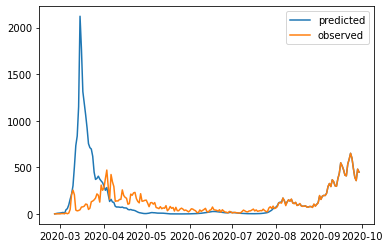

Step: 405, Time: 0.08391451835632324, Loss: 75286.234375, Mean Expected Daily Hospit: 165.52560424804688
Step: 410, Time: 0.06971001625061035, Loss: 74109.09375, Mean Expected Daily Hospit: 164.85617065429688
Step: 415, Time: 0.07495832443237305, Loss: 72964.109375, Mean Expected Daily Hospit: 164.19921875
Step: 420, Time: 0.07321929931640625, Loss: 71849.90625, Mean Expected Daily Hospit: 163.5574951171875
Step: 425, Time: 0.07591605186462402, Loss: 70765.484375, Mean Expected Daily Hospit: 162.9296875
Step: 430, Time: 0.07841134071350098, Loss: 69709.6953125, Mean Expected Daily Hospit: 162.31536865234375
Step: 435, Time: 0.0729668140411377, Loss: 68681.46875, Mean Expected Daily Hospit: 161.7127227783203
Step: 440, Time: 0.07686781883239746, Loss: 67679.734375, Mean Expected Daily Hospit: 161.12290954589844
Step: 445, Time: 0.07773733139038086, Loss: 66703.6484375, Mean Expected Daily Hospit: 160.5452423095703
Step: 450, Time: 0.08327317237854004, Loss: 65752.296875, Mean Expected D

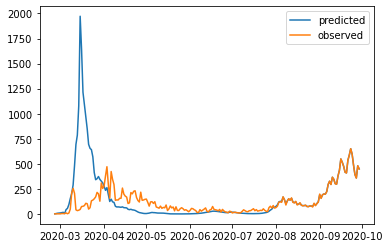

Step: 455, Time: 0.08533811569213867, Loss: 64824.640625, Mean Expected Daily Hospit: 159.42453002929688
Step: 460, Time: 0.07620596885681152, Loss: 63920.08203125, Mean Expected Daily Hospit: 158.88258361816406
Step: 465, Time: 0.07942557334899902, Loss: 63037.65625, Mean Expected Daily Hospit: 158.3538360595703
Step: 470, Time: 0.07666873931884766, Loss: 62176.78515625, Mean Expected Daily Hospit: 157.83444213867188
Step: 475, Time: 0.07533526420593262, Loss: 61336.546875, Mean Expected Daily Hospit: 157.32333374023438
Step: 480, Time: 0.08275890350341797, Loss: 60516.29296875, Mean Expected Daily Hospit: 156.82345581054688
Step: 485, Time: 0.07240843772888184, Loss: 59715.4375, Mean Expected Daily Hospit: 156.3330841064453
Step: 490, Time: 0.09076523780822754, Loss: 58933.32421875, Mean Expected Daily Hospit: 155.85154724121094
Step: 495, Time: 0.09160304069519043, Loss: 58169.2890625, Mean Expected Daily Hospit: 155.37867736816406
Step: 500, Time: 0.17426609992980957, Loss: 57422.7

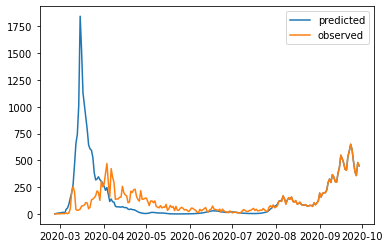

Step: 505, Time: 0.191178560256958, Loss: 56693.23046875, Mean Expected Daily Hospit: 154.46173095703125
Step: 510, Time: 0.19116663932800293, Loss: 55980.0078125, Mean Expected Daily Hospit: 154.02053833007812
Step: 515, Time: 0.16046953201293945, Loss: 55282.75390625, Mean Expected Daily Hospit: 153.58370971679688
Step: 520, Time: 0.1603858470916748, Loss: 54600.92578125, Mean Expected Daily Hospit: 153.15830993652344
Step: 525, Time: 0.15417265892028809, Loss: 53934.01171875, Mean Expected Daily Hospit: 152.7336883544922
Step: 530, Time: 0.13048768043518066, Loss: 53281.546875, Mean Expected Daily Hospit: 152.32400512695312
Step: 535, Time: 0.1375751495361328, Loss: 52643.12890625, Mean Expected Daily Hospit: 151.9228515625
Step: 540, Time: 0.12537884712219238, Loss: 52018.265625, Mean Expected Daily Hospit: 151.52420043945312
Step: 545, Time: 0.12700486183166504, Loss: 51406.625, Mean Expected Daily Hospit: 151.14369201660156
Step: 550, Time: 0.13179373741149902, Loss: 50807.835937

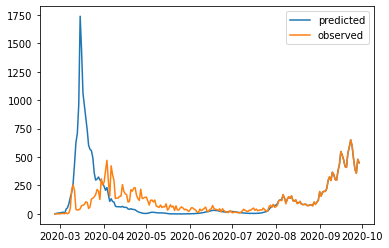

Step: 555, Time: 0.12846136093139648, Loss: 50221.453125, Mean Expected Daily Hospit: 150.4710235595703
Step: 560, Time: 0.12786602973937988, Loss: 49648.19140625, Mean Expected Daily Hospit: 149.59469604492188
Step: 565, Time: 0.19531774520874023, Loss: 49092.66796875, Mean Expected Daily Hospit: 150.8125762939453
Step: 570, Time: 0.16090750694274902, Loss: 48537.3203125, Mean Expected Daily Hospit: 150.10948181152344
Step: 575, Time: 0.13276934623718262, Loss: 47995.6953125, Mean Expected Daily Hospit: 149.58811950683594
Step: 580, Time: 0.12849974632263184, Loss: 47465.33984375, Mean Expected Daily Hospit: 149.09495544433594
Step: 585, Time: 0.1460733413696289, Loss: 46945.6640625, Mean Expected Daily Hospit: 148.59091186523438
Step: 590, Time: 0.14635825157165527, Loss: 46436.453125, Mean Expected Daily Hospit: 148.10023498535156
Step: 595, Time: 0.14056158065795898, Loss: 45937.44140625, Mean Expected Daily Hospit: 147.65701293945312
Step: 600, Time: 0.14368247985839844, Loss: 454

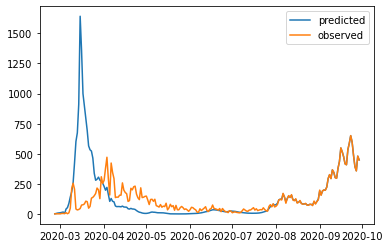

Step: 605, Time: 0.1349942684173584, Loss: 44968.29296875, Mean Expected Daily Hospit: 146.92486572265625
Step: 610, Time: 0.12711811065673828, Loss: 44497.40625, Mean Expected Daily Hospit: 146.61257934570312
Step: 615, Time: 0.1283876895904541, Loss: 44035.4140625, Mean Expected Daily Hospit: 146.31939697265625
Step: 620, Time: 0.1321570873260498, Loss: 43582.01953125, Mean Expected Daily Hospit: 146.03555297851562
Step: 625, Time: 0.12982869148254395, Loss: 43136.95703125, Mean Expected Daily Hospit: 145.75677490234375
Step: 630, Time: 0.12911486625671387, Loss: 42700.0703125, Mean Expected Daily Hospit: 145.48495483398438
Step: 635, Time: 0.1333160400390625, Loss: 42271.109375, Mean Expected Daily Hospit: 145.21682739257812
Step: 640, Time: 0.13256072998046875, Loss: 41849.91796875, Mean Expected Daily Hospit: 144.9525604248047
Step: 645, Time: 0.14053583145141602, Loss: 41436.1875, Mean Expected Daily Hospit: 144.6907196044922
Step: 650, Time: 0.13521718978881836, Loss: 41029.8906

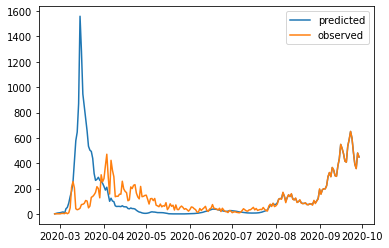

Step: 655, Time: 0.13480806350708008, Loss: 40630.73046875, Mean Expected Daily Hospit: 144.18045043945312
Step: 660, Time: 0.1286334991455078, Loss: 40238.50390625, Mean Expected Daily Hospit: 143.92979431152344
Step: 665, Time: 0.1287384033203125, Loss: 39853.0859375, Mean Expected Daily Hospit: 143.6815185546875
Step: 670, Time: 0.12172579765319824, Loss: 39474.3046875, Mean Expected Daily Hospit: 143.43360900878906
Step: 675, Time: 0.1297616958618164, Loss: 39101.9765625, Mean Expected Daily Hospit: 143.18955993652344
Step: 680, Time: 0.130873441696167, Loss: 38735.96484375, Mean Expected Daily Hospit: 142.95449829101562
Step: 685, Time: 0.13019990921020508, Loss: 38376.125, Mean Expected Daily Hospit: 142.72589111328125
Step: 690, Time: 0.128662109375, Loss: 38022.21484375, Mean Expected Daily Hospit: 142.4986114501953
Step: 695, Time: 0.15373921394348145, Loss: 37674.2109375, Mean Expected Daily Hospit: 142.27984619140625
Step: 700, Time: 0.15086627006530762, Loss: 37331.9453125,

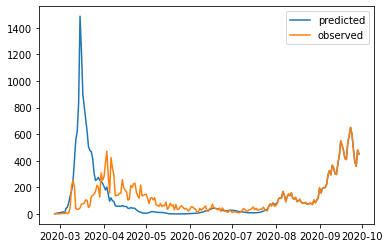

Step: 705, Time: 0.32456398010253906, Loss: 36995.23046875, Mean Expected Daily Hospit: 141.84764099121094
Step: 710, Time: 0.19837117195129395, Loss: 36663.9609375, Mean Expected Daily Hospit: 141.63552856445312
Step: 715, Time: 0.17664885520935059, Loss: 36338.0078125, Mean Expected Daily Hospit: 141.4332275390625
Step: 720, Time: 0.18795228004455566, Loss: 36017.2265625, Mean Expected Daily Hospit: 141.23390197753906
Step: 725, Time: 0.1734766960144043, Loss: 35701.53515625, Mean Expected Daily Hospit: 141.03121948242188
Step: 730, Time: 0.17693805694580078, Loss: 35390.80078125, Mean Expected Daily Hospit: 140.84217834472656
Step: 735, Time: 0.1427147388458252, Loss: 35084.87890625, Mean Expected Daily Hospit: 140.64230346679688
Step: 740, Time: 0.1407947540283203, Loss: 34783.69140625, Mean Expected Daily Hospit: 140.47413635253906
Step: 745, Time: 0.14535260200500488, Loss: 34487.140625, Mean Expected Daily Hospit: 140.25730895996094
Step: 750, Time: 0.16390132904052734, Loss: 34

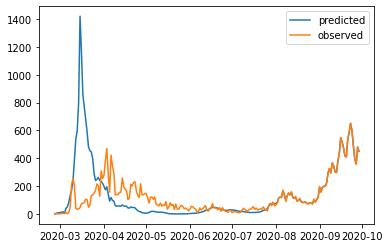

Step: 755, Time: 0.16492390632629395, Loss: 33907.52734375, Mean Expected Daily Hospit: 139.77969360351562
Step: 760, Time: 0.1365501880645752, Loss: 33625.3671875, Mean Expected Daily Hospit: 140.21142578125
Step: 765, Time: 0.1433877944946289, Loss: 33350.92578125, Mean Expected Daily Hospit: 138.5904541015625
Step: 770, Time: 0.1324000358581543, Loss: 33070.828125, Mean Expected Daily Hospit: 139.05201721191406
Step: 775, Time: 0.13465142250061035, Loss: 32799.1015625, Mean Expected Daily Hospit: 139.30384826660156
Step: 780, Time: 0.19980382919311523, Loss: 32532.435546875, Mean Expected Daily Hospit: 139.32264709472656
Step: 785, Time: 0.1954178810119629, Loss: 32269.451171875, Mean Expected Daily Hospit: 139.20994567871094
Step: 790, Time: 0.14234304428100586, Loss: 32009.984375, Mean Expected Daily Hospit: 139.02391052246094
Step: 795, Time: 0.17225265502929688, Loss: 31754.115234375, Mean Expected Daily Hospit: 138.7985382080078
Step: 800, Time: 0.1564042568206787, Loss: 31501.

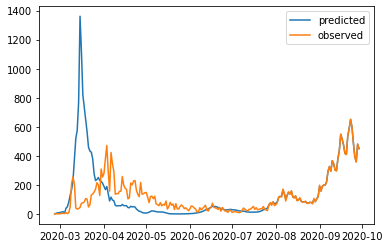

Step: 805, Time: 0.17337584495544434, Loss: 31253.265625, Mean Expected Daily Hospit: 138.31887817382812
Step: 810, Time: 0.14184165000915527, Loss: 31008.15625, Mean Expected Daily Hospit: 138.1201171875
Step: 815, Time: 0.14675092697143555, Loss: 30766.392578125, Mean Expected Daily Hospit: 137.9715118408203
Step: 820, Time: 0.1328442096710205, Loss: 30527.888671875, Mean Expected Daily Hospit: 137.86512756347656
Step: 825, Time: 0.1503443717956543, Loss: 30292.6171875, Mean Expected Daily Hospit: 137.77650451660156
Step: 830, Time: 0.14345955848693848, Loss: 30060.513671875, Mean Expected Daily Hospit: 137.66891479492188
Step: 835, Time: 0.12464332580566406, Loss: 29831.48828125, Mean Expected Daily Hospit: 137.5203857421875
Step: 840, Time: 0.16195440292358398, Loss: 29605.439453125, Mean Expected Daily Hospit: 137.36459350585938
Step: 845, Time: 0.16011500358581543, Loss: 29382.353515625, Mean Expected Daily Hospit: 137.2328338623047
Step: 850, Time: 0.18981528282165527, Loss: 291

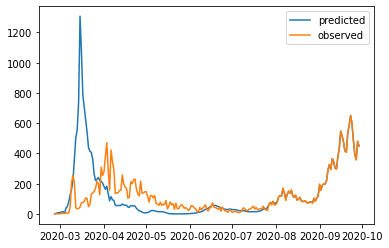

Step: 855, Time: 0.14586329460144043, Loss: 28944.755859375, Mean Expected Daily Hospit: 137.0157928466797
Step: 860, Time: 0.1312847137451172, Loss: 28730.087890625, Mean Expected Daily Hospit: 136.8831329345703
Step: 865, Time: 0.12968826293945312, Loss: 28518.13671875, Mean Expected Daily Hospit: 136.7683563232422
Step: 870, Time: 0.13390445709228516, Loss: 28308.8359375, Mean Expected Daily Hospit: 136.6654052734375
Step: 875, Time: 0.1226956844329834, Loss: 28102.083984375, Mean Expected Daily Hospit: 136.54603576660156
Step: 880, Time: 0.12883853912353516, Loss: 27897.86328125, Mean Expected Daily Hospit: 136.4378204345703
Step: 885, Time: 0.1340937614440918, Loss: 27696.0859375, Mean Expected Daily Hospit: 136.33587646484375
Step: 890, Time: 0.13530325889587402, Loss: 27496.71484375, Mean Expected Daily Hospit: 136.23048400878906
Step: 895, Time: 0.12689495086669922, Loss: 27299.7109375, Mean Expected Daily Hospit: 136.12423706054688
Step: 900, Time: 0.12404441833496094, Loss: 2

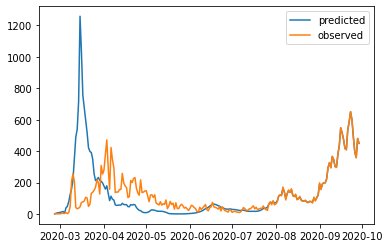

Step: 905, Time: 0.12976455688476562, Loss: 26912.544921875, Mean Expected Daily Hospit: 135.91310119628906
Step: 910, Time: 0.1277446746826172, Loss: 26722.283203125, Mean Expected Daily Hospit: 135.90782165527344
Step: 915, Time: 0.12717819213867188, Loss: 26534.533203125, Mean Expected Daily Hospit: 135.48968505859375
Step: 920, Time: 0.15485072135925293, Loss: 26353.1875, Mean Expected Daily Hospit: 136.580322265625
Step: 925, Time: 0.14304661750793457, Loss: 26165.41796875, Mean Expected Daily Hospit: 135.11180114746094
Step: 930, Time: 0.14202308654785156, Loss: 25984.451171875, Mean Expected Daily Hospit: 134.87802124023438
Step: 935, Time: 0.14029717445373535, Loss: 25803.89453125, Mean Expected Daily Hospit: 134.8804931640625
Step: 940, Time: 0.12984752655029297, Loss: 25625.21484375, Mean Expected Daily Hospit: 134.9095458984375
Step: 945, Time: 0.15214323997497559, Loss: 25448.609375, Mean Expected Daily Hospit: 134.92234802246094
Step: 950, Time: 0.1560516357421875, Loss: 2

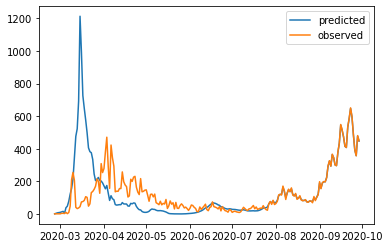

Step: 955, Time: 0.13959264755249023, Loss: 25101.171875, Mean Expected Daily Hospit: 134.90225219726562
Step: 960, Time: 0.14414048194885254, Loss: 24930.1796875, Mean Expected Daily Hospit: 134.87852478027344
Step: 965, Time: 0.14083361625671387, Loss: 24760.869140625, Mean Expected Daily Hospit: 134.84996032714844
Step: 970, Time: 0.1426851749420166, Loss: 24593.22265625, Mean Expected Daily Hospit: 134.82107543945312
Step: 975, Time: 0.12417817115783691, Loss: 24427.154296875, Mean Expected Daily Hospit: 134.79248046875
Step: 980, Time: 0.12530970573425293, Loss: 24262.669921875, Mean Expected Daily Hospit: 134.7666015625
Step: 985, Time: 0.12670087814331055, Loss: 24099.69921875, Mean Expected Daily Hospit: 134.74024963378906
Step: 990, Time: 0.13288378715515137, Loss: 23938.185546875, Mean Expected Daily Hospit: 134.71047973632812
Step: 995, Time: 0.13655757904052734, Loss: 23778.080078125, Mean Expected Daily Hospit: 134.6700897216797
Step: 1000, Time: 0.1334531307220459, Loss: 

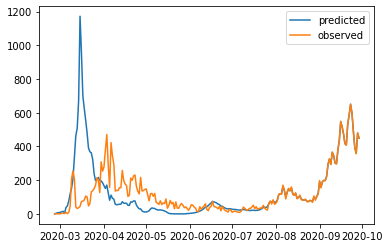

Step: 1005, Time: 0.13159608840942383, Loss: 23462.005859375, Mean Expected Daily Hospit: 134.57933044433594
Step: 1010, Time: 0.13157153129577637, Loss: 23305.94140625, Mean Expected Daily Hospit: 134.52981567382812
Step: 1015, Time: 0.13318896293640137, Loss: 23151.134765625, Mean Expected Daily Hospit: 134.48828125
Step: 1020, Time: 0.1005098819732666, Loss: 22997.55078125, Mean Expected Daily Hospit: 134.4612579345703
Step: 1025, Time: 0.07633495330810547, Loss: 22845.14453125, Mean Expected Daily Hospit: 134.4456787109375
Step: 1030, Time: 0.07245063781738281, Loss: 22693.8828125, Mean Expected Daily Hospit: 134.4310302734375
Step: 1035, Time: 0.06958723068237305, Loss: 22543.76171875, Mean Expected Daily Hospit: 134.41407775878906
Step: 1040, Time: 0.0711522102355957, Loss: 22394.67578125, Mean Expected Daily Hospit: 134.3977508544922
Step: 1045, Time: 0.06894254684448242, Loss: 22246.658203125, Mean Expected Daily Hospit: 134.3955078125
Step: 1050, Time: 0.07204914093017578, Los

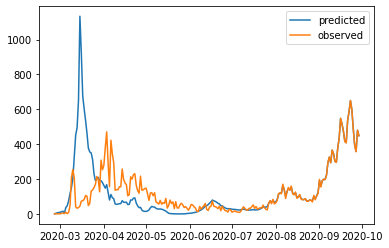

Step: 1055, Time: 0.07107925415039062, Loss: 21953.578125, Mean Expected Daily Hospit: 134.39279174804688
Step: 1060, Time: 0.07139134407043457, Loss: 21808.45703125, Mean Expected Daily Hospit: 134.40101623535156
Step: 1065, Time: 0.06918549537658691, Loss: 21664.24609375, Mean Expected Daily Hospit: 134.4230194091797
Step: 1070, Time: 0.06993579864501953, Loss: 21520.908203125, Mean Expected Daily Hospit: 134.423828125
Step: 1075, Time: 0.06836342811584473, Loss: 21378.416015625, Mean Expected Daily Hospit: 134.46240234375
Step: 1080, Time: 0.07214760780334473, Loss: 21236.71484375, Mean Expected Daily Hospit: 134.47906494140625
Step: 1085, Time: 0.07111167907714844, Loss: 21095.8125, Mean Expected Daily Hospit: 134.5303497314453
Step: 1090, Time: 0.0696415901184082, Loss: 20955.671875, Mean Expected Daily Hospit: 134.54013061523438
Step: 1095, Time: 0.06984472274780273, Loss: 20816.263671875, Mean Expected Daily Hospit: 134.6457061767578
Step: 1100, Time: 0.0694735050201416, Loss: 2

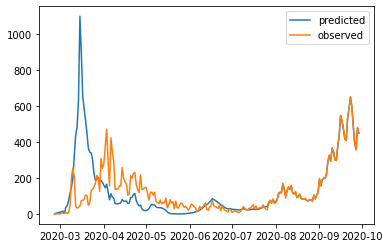

Step: 1105, Time: 0.06880879402160645, Loss: 20540.01171875, Mean Expected Daily Hospit: 134.97674560546875
Step: 1110, Time: 0.07117366790771484, Loss: 20405.70703125, Mean Expected Daily Hospit: 134.0264434814453
Step: 1115, Time: 0.0707406997680664, Loss: 20269.0859375, Mean Expected Daily Hospit: 135.60110473632812
Step: 1120, Time: 0.06915783882141113, Loss: 20132.04296875, Mean Expected Daily Hospit: 135.54017639160156
Step: 1125, Time: 0.08072948455810547, Loss: 19994.767578125, Mean Expected Daily Hospit: 135.2132568359375
Step: 1130, Time: 0.07492995262145996, Loss: 19859.974609375, Mean Expected Daily Hospit: 134.9859161376953
Step: 1135, Time: 0.07286524772644043, Loss: 19726.35546875, Mean Expected Daily Hospit: 134.9410858154297
Step: 1140, Time: 0.07949018478393555, Loss: 19593.06640625, Mean Expected Daily Hospit: 135.05975341796875
Step: 1145, Time: 0.07300281524658203, Loss: 19460.267578125, Mean Expected Daily Hospit: 135.2806396484375
Step: 1150, Time: 0.075258493423

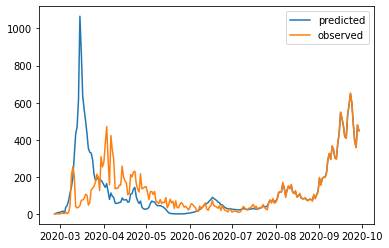

Step: 1155, Time: 0.08849072456359863, Loss: 19197.275390625, Mean Expected Daily Hospit: 135.73155212402344
Step: 1160, Time: 0.08585119247436523, Loss: 19066.958984375, Mean Expected Daily Hospit: 135.85501098632812
Step: 1165, Time: 0.07872796058654785, Loss: 18937.4296875, Mean Expected Daily Hospit: 135.92572021484375
Step: 1170, Time: 0.07310223579406738, Loss: 18808.83203125, Mean Expected Daily Hospit: 136.00511169433594
Step: 1175, Time: 0.07048916816711426, Loss: 18681.158203125, Mean Expected Daily Hospit: 136.14617919921875
Step: 1180, Time: 0.06971573829650879, Loss: 18554.45703125, Mean Expected Daily Hospit: 136.3349151611328
Step: 1185, Time: 0.06874752044677734, Loss: 18428.845703125, Mean Expected Daily Hospit: 136.51271057128906
Step: 1190, Time: 0.06796717643737793, Loss: 18304.3671875, Mean Expected Daily Hospit: 136.65284729003906
Step: 1195, Time: 0.07674717903137207, Loss: 18181.126953125, Mean Expected Daily Hospit: 136.7813262939453
Step: 1200, Time: 0.0870652

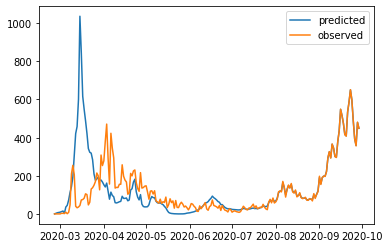

Step: 1205, Time: 0.08631086349487305, Loss: 17938.630859375, Mean Expected Daily Hospit: 137.1353302001953
Step: 1210, Time: 0.0757148265838623, Loss: 17819.541015625, Mean Expected Daily Hospit: 137.27723693847656
Step: 1215, Time: 0.09665131568908691, Loss: 17702.0234375, Mean Expected Daily Hospit: 137.43328857421875
Step: 1220, Time: 0.08271527290344238, Loss: 17586.142578125, Mean Expected Daily Hospit: 137.60845947265625
Step: 1225, Time: 0.06992650032043457, Loss: 17471.966796875, Mean Expected Daily Hospit: 137.7344512939453
Step: 1230, Time: 0.07115697860717773, Loss: 17359.5390625, Mean Expected Daily Hospit: 137.91302490234375
Step: 1235, Time: 0.06796765327453613, Loss: 17248.94140625, Mean Expected Daily Hospit: 138.01461791992188
Step: 1240, Time: 0.07071685791015625, Loss: 17140.162109375, Mean Expected Daily Hospit: 138.20729064941406
Step: 1245, Time: 0.06806373596191406, Loss: 17033.29296875, Mean Expected Daily Hospit: 138.2094268798828
Step: 1250, Time: 0.068819761

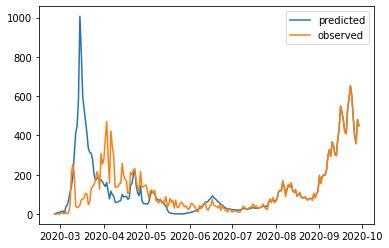

Step: 1255, Time: 0.08160519599914551, Loss: 16827.94140625, Mean Expected Daily Hospit: 137.81271362304688
Step: 1260, Time: 0.08507394790649414, Loss: 16729.109375, Mean Expected Daily Hospit: 139.55874633789062
Step: 1265, Time: 0.09449505805969238, Loss: 16626.115234375, Mean Expected Daily Hospit: 139.25833129882812
Step: 1270, Time: 0.07637286186218262, Loss: 16526.388671875, Mean Expected Daily Hospit: 138.82603454589844
Step: 1275, Time: 0.07076120376586914, Loss: 16430.5703125, Mean Expected Daily Hospit: 138.57859802246094
Step: 1280, Time: 0.06797575950622559, Loss: 16336.3583984375, Mean Expected Daily Hospit: 138.5330352783203
Step: 1285, Time: 0.07352948188781738, Loss: 16243.19140625, Mean Expected Daily Hospit: 138.62928771972656
Step: 1290, Time: 0.08051300048828125, Loss: 16151.37890625, Mean Expected Daily Hospit: 138.79942321777344
Step: 1295, Time: 0.07257938385009766, Loss: 16061.208984375, Mean Expected Daily Hospit: 138.95611572265625
Step: 1300, Time: 0.0816943

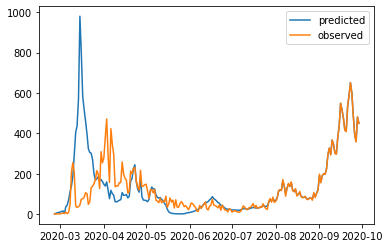

Step: 1305, Time: 0.08069849014282227, Loss: 15884.974609375, Mean Expected Daily Hospit: 139.0098876953125
Step: 1310, Time: 0.08173394203186035, Loss: 15798.6025390625, Mean Expected Daily Hospit: 138.9129180908203
Step: 1315, Time: 0.10604667663574219, Loss: 15713.4326171875, Mean Expected Daily Hospit: 138.82623291015625
Step: 1320, Time: 0.12163376808166504, Loss: 15629.32421875, Mean Expected Daily Hospit: 138.8135986328125
Step: 1325, Time: 0.1336061954498291, Loss: 15546.2451171875, Mean Expected Daily Hospit: 138.8359832763672
Step: 1330, Time: 0.18617868423461914, Loss: 15464.150390625, Mean Expected Daily Hospit: 138.81597900390625
Step: 1335, Time: 0.15979647636413574, Loss: 15383.0166015625, Mean Expected Daily Hospit: 138.73614501953125
Step: 1340, Time: 0.17865252494812012, Loss: 15302.78515625, Mean Expected Daily Hospit: 138.67762756347656
Step: 1345, Time: 0.17025303840637207, Loss: 15223.4453125, Mean Expected Daily Hospit: 138.66470336914062
Step: 1350, Time: 0.1717

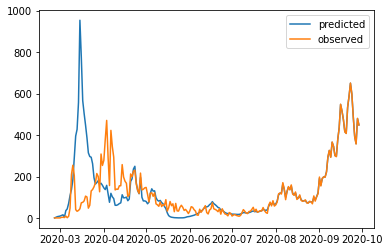

Step: 1355, Time: 0.15984082221984863, Loss: 15067.2890625, Mean Expected Daily Hospit: 138.54273986816406
Step: 1360, Time: 0.17590689659118652, Loss: 14990.421875, Mean Expected Daily Hospit: 138.51210021972656
Step: 1365, Time: 0.1698465347290039, Loss: 14914.3427734375, Mean Expected Daily Hospit: 138.45201110839844
Step: 1370, Time: 0.17676329612731934, Loss: 14839.025390625, Mean Expected Daily Hospit: 138.39910888671875
Step: 1375, Time: 0.196150541305542, Loss: 14764.4482421875, Mean Expected Daily Hospit: 138.35687255859375
Step: 1380, Time: 0.1820673942565918, Loss: 14690.5966796875, Mean Expected Daily Hospit: 138.27935791015625
Step: 1385, Time: 0.15041184425354004, Loss: 14617.4716796875, Mean Expected Daily Hospit: 138.2843780517578
Step: 1390, Time: 0.17781543731689453, Loss: 14545.109375, Mean Expected Daily Hospit: 138.07205200195312
Step: 1395, Time: 0.1756763458251953, Loss: 14474.0087890625, Mean Expected Daily Hospit: 138.48944091796875
Step: 1400, Time: 0.17343091

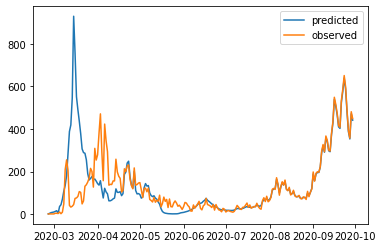

Step: 1405, Time: 0.17008185386657715, Loss: 14333.2734375, Mean Expected Daily Hospit: 138.53070068359375
Step: 1410, Time: 0.13782286643981934, Loss: 14264.98828125, Mean Expected Daily Hospit: 138.68214416503906
Step: 1415, Time: 0.14286494255065918, Loss: 14194.33984375, Mean Expected Daily Hospit: 138.41506958007812
Step: 1420, Time: 0.14272570610046387, Loss: 14124.64453125, Mean Expected Daily Hospit: 138.08001708984375
Step: 1425, Time: 0.14912891387939453, Loss: 14056.482421875, Mean Expected Daily Hospit: 137.79225158691406
Step: 1430, Time: 0.13358521461486816, Loss: 13989.3359375, Mean Expected Daily Hospit: 137.5979766845703
Step: 1435, Time: 0.12891483306884766, Loss: 13922.7216796875, Mean Expected Daily Hospit: 137.50540161132812
Step: 1440, Time: 0.15454936027526855, Loss: 13856.5185546875, Mean Expected Daily Hospit: 137.50035095214844
Step: 1445, Time: 0.14118599891662598, Loss: 13790.876953125, Mean Expected Daily Hospit: 137.54176330566406
Step: 1450, Time: 0.18845

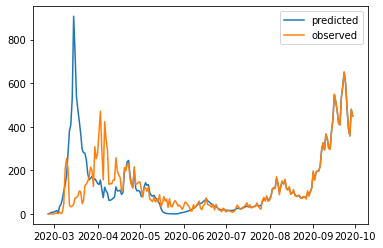

Step: 1455, Time: 0.17917418479919434, Loss: 13661.5146484375, Mean Expected Daily Hospit: 137.55105590820312
Step: 1460, Time: 0.2372293472290039, Loss: 13597.6357421875, Mean Expected Daily Hospit: 137.47036743164062
Step: 1465, Time: 0.15529894828796387, Loss: 13534.2998046875, Mean Expected Daily Hospit: 137.3628692626953
Step: 1470, Time: 0.1462724208831787, Loss: 13471.517578125, Mean Expected Daily Hospit: 137.28089904785156
Step: 1475, Time: 0.15774250030517578, Loss: 13409.244140625, Mean Expected Daily Hospit: 137.24586486816406
Step: 1480, Time: 0.1622943878173828, Loss: 13347.486328125, Mean Expected Daily Hospit: 137.22274780273438
Step: 1485, Time: 0.14316463470458984, Loss: 13286.2373046875, Mean Expected Daily Hospit: 137.16844177246094
Step: 1490, Time: 0.15933775901794434, Loss: 13225.484375, Mean Expected Daily Hospit: 137.09303283691406
Step: 1495, Time: 0.29480838775634766, Loss: 13165.2197265625, Mean Expected Daily Hospit: 137.03810119628906
Step: 1500, Time: 0.2

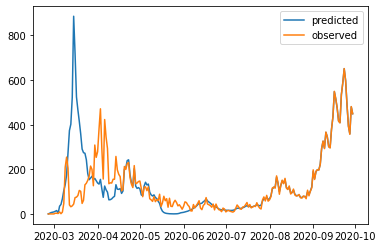

Step: 1505, Time: 0.21649432182312012, Loss: 13046.15234375, Mean Expected Daily Hospit: 136.94528198242188
Step: 1510, Time: 0.19785809516906738, Loss: 12987.3125, Mean Expected Daily Hospit: 136.87551879882812
Step: 1515, Time: 0.1738286018371582, Loss: 12928.9482421875, Mean Expected Daily Hospit: 136.84226989746094
Step: 1520, Time: 0.14815282821655273, Loss: 12871.0185546875, Mean Expected Daily Hospit: 136.77780151367188
Step: 1525, Time: 0.14972352981567383, Loss: 12813.5517578125, Mean Expected Daily Hospit: 136.72581481933594
Step: 1530, Time: 0.13618230819702148, Loss: 12756.5166015625, Mean Expected Daily Hospit: 136.68145751953125
Step: 1535, Time: 0.15578675270080566, Loss: 12699.9150390625, Mean Expected Daily Hospit: 136.62057495117188
Step: 1540, Time: 0.13928866386413574, Loss: 12643.7529296875, Mean Expected Daily Hospit: 136.58541870117188
Step: 1545, Time: 0.1775197982788086, Loss: 12588.00390625, Mean Expected Daily Hospit: 136.5002899169922
Step: 1550, Time: 0.146

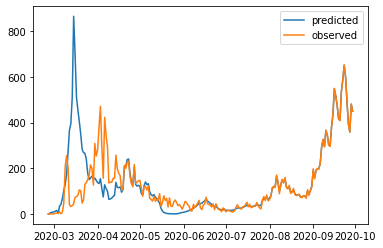

Step: 1555, Time: 0.20914053916931152, Loss: 12477.859375, Mean Expected Daily Hospit: 136.28176879882812
Step: 1560, Time: 0.25890374183654785, Loss: 12424.259765625, Mean Expected Daily Hospit: 136.7955322265625
Step: 1565, Time: 0.21541404724121094, Loss: 12376.2109375, Mean Expected Daily Hospit: 135.2224884033203
Step: 1570, Time: 0.15912413597106934, Loss: 12315.962890625, Mean Expected Daily Hospit: 136.60110473632812
Step: 1575, Time: 0.17833852767944336, Loss: 12264.6171875, Mean Expected Daily Hospit: 136.89601135253906
Step: 1580, Time: 0.16791081428527832, Loss: 12210.5166015625, Mean Expected Daily Hospit: 136.6835174560547
Step: 1585, Time: 0.16625690460205078, Loss: 12156.6962890625, Mean Expected Daily Hospit: 136.34596252441406
Step: 1590, Time: 0.15944480895996094, Loss: 12104.2060546875, Mean Expected Daily Hospit: 136.0461883544922
Step: 1595, Time: 0.13809943199157715, Loss: 12052.5341796875, Mean Expected Daily Hospit: 135.85784912109375
Step: 1600, Time: 0.145144

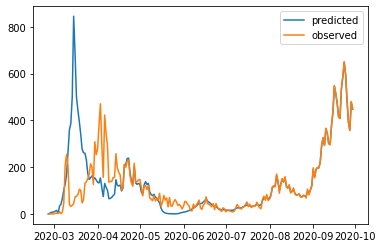

Step: 1605, Time: 0.1653909683227539, Loss: 11949.7626953125, Mean Expected Daily Hospit: 135.82737731933594
Step: 1610, Time: 0.14448070526123047, Loss: 11898.8818359375, Mean Expected Daily Hospit: 135.89483642578125
Step: 1615, Time: 0.13809657096862793, Loss: 11848.4501953125, Mean Expected Daily Hospit: 135.92715454101562
Step: 1620, Time: 0.13932013511657715, Loss: 11798.3427734375, Mean Expected Daily Hospit: 135.88677978515625
Step: 1625, Time: 0.14823269844055176, Loss: 11748.5322265625, Mean Expected Daily Hospit: 135.79251098632812
Step: 1630, Time: 0.15369701385498047, Loss: 11699.0927734375, Mean Expected Daily Hospit: 135.69949340820312
Step: 1635, Time: 0.14787650108337402, Loss: 11649.96875, Mean Expected Daily Hospit: 135.6564178466797
Step: 1640, Time: 0.14286422729492188, Loss: 11601.16796875, Mean Expected Daily Hospit: 135.64793395996094
Step: 1645, Time: 0.13967132568359375, Loss: 11552.697265625, Mean Expected Daily Hospit: 135.62643432617188
Step: 1650, Time: 0.

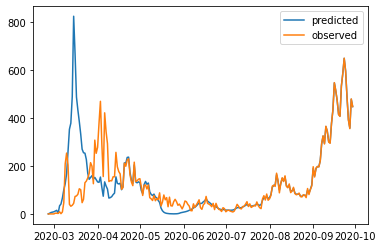

Step: 1655, Time: 0.13290953636169434, Loss: 11456.689453125, Mean Expected Daily Hospit: 135.51036071777344
Step: 1660, Time: 0.13930225372314453, Loss: 11409.150390625, Mean Expected Daily Hospit: 135.47967529296875
Step: 1665, Time: 0.13658571243286133, Loss: 11361.91796875, Mean Expected Daily Hospit: 135.46107482910156
Step: 1670, Time: 0.1807079315185547, Loss: 11314.9755859375, Mean Expected Daily Hospit: 135.40647888183594
Step: 1675, Time: 0.1532735824584961, Loss: 11268.345703125, Mean Expected Daily Hospit: 135.3623809814453
Step: 1680, Time: 0.15607118606567383, Loss: 11222.0009765625, Mean Expected Daily Hospit: 135.3448944091797
Step: 1685, Time: 0.14135169982910156, Loss: 11175.958984375, Mean Expected Daily Hospit: 135.296875
Step: 1690, Time: 0.141981840133667, Loss: 11130.1904296875, Mean Expected Daily Hospit: 135.25059509277344
Step: 1695, Time: 0.13172173500061035, Loss: 11084.712890625, Mean Expected Daily Hospit: 135.24818420410156
Step: 1700, Time: 0.14206480979

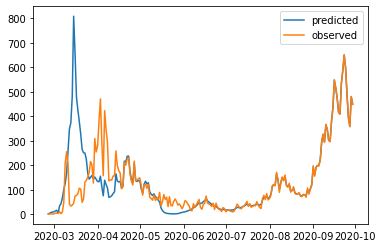

Step: 1705, Time: 0.1687612533569336, Loss: 10994.61328125, Mean Expected Daily Hospit: 135.20257568359375
Step: 1710, Time: 0.1488492488861084, Loss: 10949.9853515625, Mean Expected Daily Hospit: 135.0471649169922
Step: 1715, Time: 0.15418720245361328, Loss: 10905.705078125, Mean Expected Daily Hospit: 135.23147583007812
Step: 1720, Time: 0.12821149826049805, Loss: 10862.091796875, Mean Expected Daily Hospit: 134.73153686523438
Step: 1725, Time: 0.13526320457458496, Loss: 10820.5859375, Mean Expected Daily Hospit: 135.73175048828125
Step: 1730, Time: 0.13691234588623047, Loss: 10778.0166015625, Mean Expected Daily Hospit: 134.17044067382812
Step: 1735, Time: 0.1257491111755371, Loss: 10731.21875, Mean Expected Daily Hospit: 134.6799774169922
Step: 1740, Time: 0.14310336112976074, Loss: 10688.4755859375, Mean Expected Daily Hospit: 135.28903198242188
Step: 1745, Time: 0.1358623504638672, Loss: 10645.5419921875, Mean Expected Daily Hospit: 135.22621154785156
Step: 1750, Time: 0.12959456

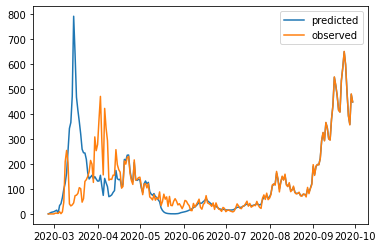

Step: 1755, Time: 0.14813971519470215, Loss: 10560.3818359375, Mean Expected Daily Hospit: 134.60841369628906
Step: 1760, Time: 0.14038753509521484, Loss: 10518.0595703125, Mean Expected Daily Hospit: 134.74114990234375
Step: 1765, Time: 0.12832927703857422, Loss: 10476.310546875, Mean Expected Daily Hospit: 134.89898681640625
Step: 1770, Time: 0.13634347915649414, Loss: 10434.6962890625, Mean Expected Daily Hospit: 134.81610107421875
Step: 1775, Time: 0.1561896800994873, Loss: 10393.3740234375, Mean Expected Daily Hospit: 134.6560516357422
Step: 1780, Time: 0.13823795318603516, Loss: 10352.2861328125, Mean Expected Daily Hospit: 134.65586853027344
Step: 1785, Time: 0.12838053703308105, Loss: 10311.4443359375, Mean Expected Daily Hospit: 134.7167205810547
Step: 1790, Time: 0.12754511833190918, Loss: 10270.82421875, Mean Expected Daily Hospit: 134.64768981933594
Step: 1795, Time: 0.24449586868286133, Loss: 10230.4541015625, Mean Expected Daily Hospit: 134.5718231201172
Step: 1800, Time:

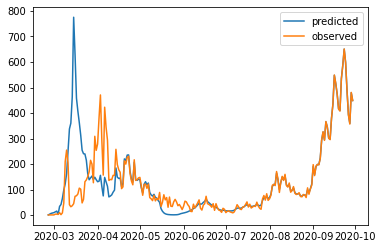

Step: 1805, Time: 0.0925140380859375, Loss: 10150.37109375, Mean Expected Daily Hospit: 134.56076049804688
Step: 1810, Time: 0.10429596900939941, Loss: 10110.677734375, Mean Expected Daily Hospit: 134.52200317382812
Step: 1815, Time: 0.07845234870910645, Loss: 10071.19921875, Mean Expected Daily Hospit: 134.53062438964844
Step: 1820, Time: 0.07668304443359375, Loss: 10031.9462890625, Mean Expected Daily Hospit: 134.47129821777344
Step: 1825, Time: 0.1247720718383789, Loss: 9992.9072265625, Mean Expected Daily Hospit: 134.47486877441406
Step: 1830, Time: 0.11076211929321289, Loss: 9954.0869140625, Mean Expected Daily Hospit: 134.4261016845703
Step: 1835, Time: 0.0805199146270752, Loss: 9915.4873046875, Mean Expected Daily Hospit: 134.44276428222656
Step: 1840, Time: 0.07700824737548828, Loss: 9877.1103515625, Mean Expected Daily Hospit: 134.32859802246094
Step: 1845, Time: 0.07751870155334473, Loss: 9839.064453125, Mean Expected Daily Hospit: 134.5384521484375
Step: 1850, Time: 0.115782

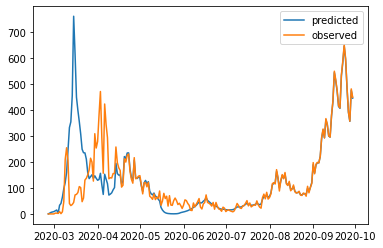

Step: 1855, Time: 0.09677743911743164, Loss: 9769.8994140625, Mean Expected Daily Hospit: 135.40187072753906
Step: 1860, Time: 0.10770606994628906, Loss: 9726.205078125, Mean Expected Daily Hospit: 133.98402404785156
Step: 1865, Time: 0.0817255973815918, Loss: 9691.1005859375, Mean Expected Daily Hospit: 133.58230590820312
Step: 1870, Time: 0.12986040115356445, Loss: 9652.1201171875, Mean Expected Daily Hospit: 133.83697509765625
Step: 1875, Time: 0.12430787086486816, Loss: 9614.1015625, Mean Expected Daily Hospit: 134.20782470703125
Step: 1880, Time: 0.11419963836669922, Loss: 9577.59765625, Mean Expected Daily Hospit: 134.4357452392578
Step: 1885, Time: 0.09779191017150879, Loss: 9541.115234375, Mean Expected Daily Hospit: 134.4522247314453
Step: 1890, Time: 0.09933638572692871, Loss: 9504.474609375, Mean Expected Daily Hospit: 134.31204223632812
Step: 1895, Time: 0.08146929740905762, Loss: 9468.189453125, Mean Expected Daily Hospit: 134.1326904296875
Step: 1900, Time: 0.098548173904

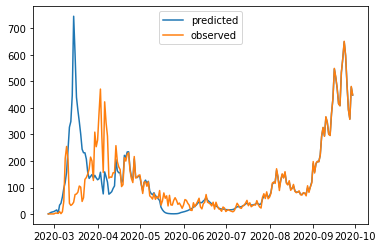

Step: 1905, Time: 0.09457159042358398, Loss: 9396.3974609375, Mean Expected Daily Hospit: 134.0491485595703
Step: 1910, Time: 0.08615398406982422, Loss: 9360.736328125, Mean Expected Daily Hospit: 134.11866760253906
Step: 1915, Time: 0.07790112495422363, Loss: 9325.306640625, Mean Expected Daily Hospit: 134.1437225341797
Step: 1920, Time: 0.09777688980102539, Loss: 9290.0283203125, Mean Expected Daily Hospit: 134.09295654296875
Step: 1925, Time: 0.09511041641235352, Loss: 9254.9404296875, Mean Expected Daily Hospit: 134.02813720703125
Step: 1930, Time: 0.08347535133361816, Loss: 9220.037109375, Mean Expected Daily Hospit: 134.01443481445312
Step: 1935, Time: 0.08365845680236816, Loss: 9185.3017578125, Mean Expected Daily Hospit: 134.0263671875
Step: 1940, Time: 0.08245658874511719, Loss: 9150.75, Mean Expected Daily Hospit: 134.01768493652344
Step: 1945, Time: 0.08850836753845215, Loss: 9116.36328125, Mean Expected Daily Hospit: 133.97657775878906
Step: 1950, Time: 0.07557129859924316,

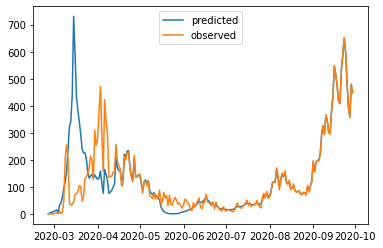

Step: 1955, Time: 0.0912022590637207, Loss: 9048.103515625, Mean Expected Daily Hospit: 133.95623779296875
Step: 1960, Time: 0.07768416404724121, Loss: 9014.224609375, Mean Expected Daily Hospit: 133.93734741210938
Step: 1965, Time: 0.08064007759094238, Loss: 8980.5146484375, Mean Expected Daily Hospit: 133.91859436035156
Step: 1970, Time: 0.08754968643188477, Loss: 8946.96484375, Mean Expected Daily Hospit: 133.90408325195312
Step: 1975, Time: 0.15948486328125, Loss: 8913.5771484375, Mean Expected Daily Hospit: 133.89259338378906
Step: 1980, Time: 0.07798004150390625, Loss: 8880.3583984375, Mean Expected Daily Hospit: 133.87225341796875
Step: 1985, Time: 0.08034753799438477, Loss: 8847.2900390625, Mean Expected Daily Hospit: 133.86399841308594
Step: 1990, Time: 0.08640432357788086, Loss: 8814.37890625, Mean Expected Daily Hospit: 133.8392791748047
Step: 1995, Time: 0.07770085334777832, Loss: 8781.626953125, Mean Expected Daily Hospit: 133.8441162109375
Step: 2000, Time: 0.081666231155

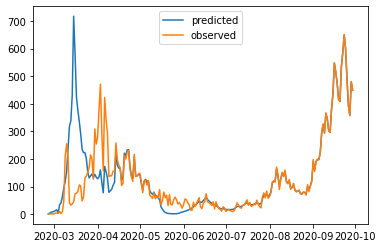

Step: 2005, Time: 0.08342981338500977, Loss: 8716.595703125, Mean Expected Daily Hospit: 133.84608459472656
Step: 2010, Time: 0.07989025115966797, Loss: 8684.353515625, Mean Expected Daily Hospit: 133.68093872070312
Step: 2015, Time: 0.07694888114929199, Loss: 8652.70703125, Mean Expected Daily Hospit: 134.08966064453125
Step: 2020, Time: 0.07641363143920898, Loss: 8624.7421875, Mean Expected Daily Hospit: 132.87503051757812
Step: 2025, Time: 0.08495950698852539, Loss: 8594.0625, Mean Expected Daily Hospit: 134.75189208984375
Step: 2030, Time: 0.08112549781799316, Loss: 8559.1962890625, Mean Expected Daily Hospit: 134.41270446777344
Step: 2035, Time: 0.08021402359008789, Loss: 8525.03125, Mean Expected Daily Hospit: 133.79295349121094
Step: 2040, Time: 0.09473490715026855, Loss: 8494.1025390625, Mean Expected Daily Hospit: 133.4168701171875
Step: 2045, Time: 0.10971570014953613, Loss: 8463.0986328125, Mean Expected Daily Hospit: 133.33123779296875
Step: 2050, Time: 0.0929558277130127, 

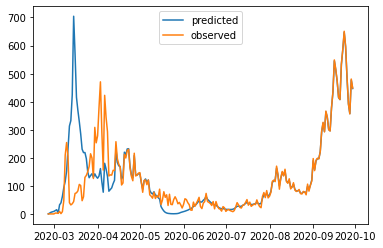

Step: 2055, Time: 0.08217692375183105, Loss: 8400.1552734375, Mean Expected Daily Hospit: 133.62765502929688
Step: 2060, Time: 0.08258986473083496, Loss: 8369.318359375, Mean Expected Daily Hospit: 133.76637268066406
Step: 2065, Time: 0.0896294116973877, Loss: 8338.6298828125, Mean Expected Daily Hospit: 133.79425048828125
Step: 2070, Time: 0.0821845531463623, Loss: 8307.9375, Mean Expected Daily Hospit: 133.7215118408203
Step: 2075, Time: 0.09297657012939453, Loss: 8277.4296875, Mean Expected Daily Hospit: 133.6200714111328
Step: 2080, Time: 0.07913827896118164, Loss: 8247.1064453125, Mean Expected Daily Hospit: 133.56309509277344
Step: 2085, Time: 0.0828099250793457, Loss: 8216.8701171875, Mean Expected Daily Hospit: 133.57763671875
Step: 2090, Time: 0.09318327903747559, Loss: 8186.77001953125, Mean Expected Daily Hospit: 133.6207733154297
Step: 2095, Time: 0.12746381759643555, Loss: 8156.80712890625, Mean Expected Daily Hospit: 133.62530517578125
Step: 2100, Time: 0.1478841304779052

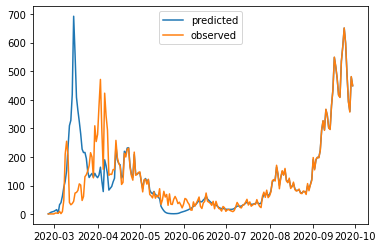

Step: 2105, Time: 0.14162874221801758, Loss: 8097.23779296875, Mean Expected Daily Hospit: 133.55677795410156
Step: 2110, Time: 0.13768434524536133, Loss: 8067.63720703125, Mean Expected Daily Hospit: 133.56089782714844
Step: 2115, Time: 0.18826055526733398, Loss: 8038.1611328125, Mean Expected Daily Hospit: 133.5709991455078
Step: 2120, Time: 0.16941142082214355, Loss: 8008.8017578125, Mean Expected Daily Hospit: 133.5503692626953
Step: 2125, Time: 0.15574884414672852, Loss: 7979.55712890625, Mean Expected Daily Hospit: 133.53517150878906
Step: 2130, Time: 0.14906573295593262, Loss: 7950.4345703125, Mean Expected Daily Hospit: 133.53485107421875
Step: 2135, Time: 0.16334867477416992, Loss: 7921.42724609375, Mean Expected Daily Hospit: 133.52513122558594
Step: 2140, Time: 0.14496278762817383, Loss: 7892.53955078125, Mean Expected Daily Hospit: 133.5140380859375
Step: 2145, Time: 0.14799284934997559, Loss: 7863.76123046875, Mean Expected Daily Hospit: 133.51263427734375
Step: 2150, Time

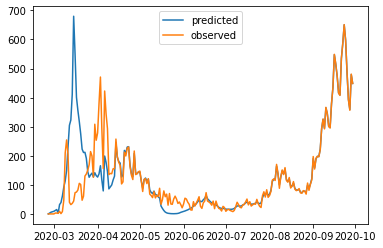

Step: 2155, Time: 0.24570155143737793, Loss: 7806.54052734375, Mean Expected Daily Hospit: 133.4928436279297
Step: 2160, Time: 0.15763449668884277, Loss: 7778.09912109375, Mean Expected Daily Hospit: 133.49229431152344
Step: 2165, Time: 0.152360200881958, Loss: 7749.7646484375, Mean Expected Daily Hospit: 133.46910095214844
Step: 2170, Time: 0.21024560928344727, Loss: 7721.541015625, Mean Expected Daily Hospit: 133.4923553466797
Step: 2175, Time: 0.1568598747253418, Loss: 7693.4345703125, Mean Expected Daily Hospit: 133.43222045898438
Step: 2180, Time: 0.1844651699066162, Loss: 7665.45703125, Mean Expected Daily Hospit: 133.53857421875
Step: 2185, Time: 0.17517447471618652, Loss: 7637.7265625, Mean Expected Daily Hospit: 133.2659454345703
Step: 2190, Time: 0.15564656257629395, Loss: 7611.15283203125, Mean Expected Daily Hospit: 133.94459533691406
Step: 2195, Time: 0.16397666931152344, Loss: 7589.18359375, Mean Expected Daily Hospit: 132.33287048339844
Step: 2200, Time: 0.13164281845092

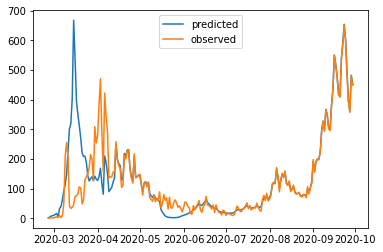

Step: 2205, Time: 0.14258313179016113, Loss: 7529.7412109375, Mean Expected Daily Hospit: 134.12586975097656
Step: 2210, Time: 0.12664341926574707, Loss: 7500.087890625, Mean Expected Daily Hospit: 133.72018432617188
Step: 2215, Time: 0.18669533729553223, Loss: 7472.45556640625, Mean Expected Daily Hospit: 133.2688446044922
Step: 2220, Time: 0.16558146476745605, Loss: 7445.7197265625, Mean Expected Daily Hospit: 133.1042022705078
Step: 2225, Time: 0.24315428733825684, Loss: 7418.283203125, Mean Expected Daily Hospit: 133.22747802734375
Step: 2230, Time: 0.15063714981079102, Loss: 7391.11376953125, Mean Expected Daily Hospit: 133.44674682617188
Step: 2235, Time: 0.15889883041381836, Loss: 7364.35546875, Mean Expected Daily Hospit: 133.5511016845703
Step: 2240, Time: 0.1493382453918457, Loss: 7337.5009765625, Mean Expected Daily Hospit: 133.4833984375
Step: 2245, Time: 0.14354205131530762, Loss: 7310.8056640625, Mean Expected Daily Hospit: 133.35975646972656
Step: 2250, Time: 0.223885774

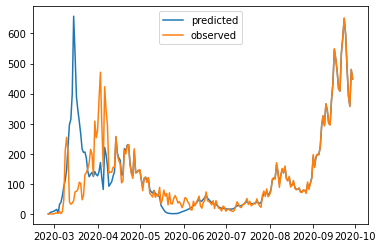

Step: 2255, Time: 0.1603989601135254, Loss: 7257.7470703125, Mean Expected Daily Hospit: 133.3836669921875
Step: 2260, Time: 0.1407613754272461, Loss: 7231.38330078125, Mean Expected Daily Hospit: 133.43255615234375
Step: 2265, Time: 0.14208269119262695, Loss: 7205.09814453125, Mean Expected Daily Hospit: 133.40147399902344
Step: 2270, Time: 0.14970755577087402, Loss: 7178.92431640625, Mean Expected Daily Hospit: 133.35739135742188
Step: 2275, Time: 0.15386247634887695, Loss: 7152.83740234375, Mean Expected Daily Hospit: 133.37474060058594
Step: 2280, Time: 0.1604905128479004, Loss: 7126.85791015625, Mean Expected Daily Hospit: 133.3946075439453
Step: 2285, Time: 0.16801166534423828, Loss: 7100.96826171875, Mean Expected Daily Hospit: 133.37820434570312
Step: 2290, Time: 0.1512312889099121, Loss: 7075.1767578125, Mean Expected Daily Hospit: 133.36679077148438
Step: 2295, Time: 0.14617681503295898, Loss: 7049.48291015625, Mean Expected Daily Hospit: 133.38211059570312
Step: 2300, Time: 

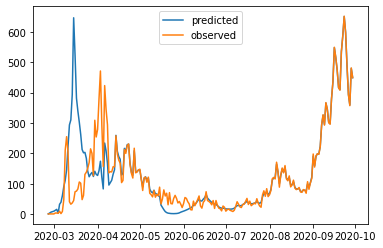

Step: 2305, Time: 0.1622166633605957, Loss: 6998.38671875, Mean Expected Daily Hospit: 133.3641357421875
Step: 2310, Time: 0.21791744232177734, Loss: 6972.982421875, Mean Expected Daily Hospit: 133.383544921875
Step: 2315, Time: 0.24807453155517578, Loss: 6947.67724609375, Mean Expected Daily Hospit: 133.3553009033203
Step: 2320, Time: 0.2104945182800293, Loss: 6922.4658203125, Mean Expected Daily Hospit: 133.3905029296875
Step: 2325, Time: 0.20588135719299316, Loss: 6897.3564453125, Mean Expected Daily Hospit: 133.34339904785156
Step: 2330, Time: 0.24228930473327637, Loss: 6872.34326171875, Mean Expected Daily Hospit: 133.40769958496094
Step: 2335, Time: 0.16107964515686035, Loss: 6847.451171875, Mean Expected Daily Hospit: 133.28875732421875
Step: 2340, Time: 0.14873361587524414, Loss: 6822.798828125, Mean Expected Daily Hospit: 133.5592041015625
Step: 2345, Time: 0.17804837226867676, Loss: 6799.29345703125, Mean Expected Daily Hospit: 132.87118530273438
Step: 2350, Time: 0.171663045

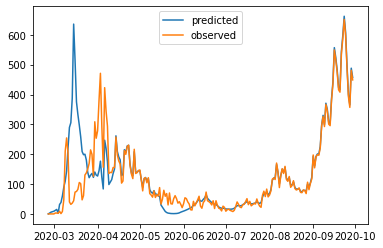

Step: 2355, Time: 0.14681720733642578, Loss: 6750.06494140625, Mean Expected Daily Hospit: 132.8869171142578
Step: 2360, Time: 0.14939260482788086, Loss: 6727.11376953125, Mean Expected Daily Hospit: 132.66822814941406
Step: 2365, Time: 0.1503751277923584, Loss: 6700.11181640625, Mean Expected Daily Hospit: 133.19488525390625
Step: 2370, Time: 0.15091991424560547, Loss: 6676.1044921875, Mean Expected Daily Hospit: 133.6424102783203
Step: 2375, Time: 0.1366739273071289, Loss: 6652.14990234375, Mean Expected Daily Hospit: 133.69784545898438
Step: 2380, Time: 0.14279985427856445, Loss: 6627.5576171875, Mean Expected Daily Hospit: 133.47122192382812
Step: 2385, Time: 0.1405177116394043, Loss: 6603.65625, Mean Expected Daily Hospit: 133.25047302246094
Step: 2390, Time: 0.14266276359558105, Loss: 6579.84326171875, Mean Expected Daily Hospit: 133.2300567626953
Step: 2395, Time: 0.1489269733428955, Loss: 6555.97216796875, Mean Expected Daily Hospit: 133.3697967529297
Step: 2400, Time: 0.139428

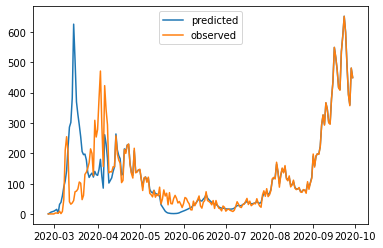

Step: 2405, Time: 0.14073967933654785, Loss: 6508.78955078125, Mean Expected Daily Hospit: 133.4250946044922
Step: 2410, Time: 0.15099668502807617, Loss: 6485.34228515625, Mean Expected Daily Hospit: 133.34576416015625
Step: 2415, Time: 0.13399076461791992, Loss: 6461.99072265625, Mean Expected Daily Hospit: 133.35238647460938
Step: 2420, Time: 0.15224552154541016, Loss: 6438.7421875, Mean Expected Daily Hospit: 133.41650390625
Step: 2425, Time: 0.135908842086792, Loss: 6415.5966796875, Mean Expected Daily Hospit: 133.41348266601562
Step: 2430, Time: 0.15221762657165527, Loss: 6392.55029296875, Mean Expected Daily Hospit: 133.37472534179688
Step: 2435, Time: 0.1403059959411621, Loss: 6369.60546875, Mean Expected Daily Hospit: 133.394287109375
Step: 2440, Time: 0.1384444236755371, Loss: 6346.76416015625, Mean Expected Daily Hospit: 133.4163818359375
Step: 2445, Time: 0.1378331184387207, Loss: 6324.03076171875, Mean Expected Daily Hospit: 133.39854431152344
Step: 2450, Time: 0.1368465423

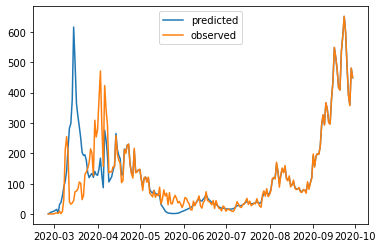

Step: 2455, Time: 0.14266276359558105, Loss: 6278.861328125, Mean Expected Daily Hospit: 133.4186553955078
Step: 2460, Time: 0.1550753116607666, Loss: 6256.43896484375, Mean Expected Daily Hospit: 133.40997314453125
Step: 2465, Time: 0.13804268836975098, Loss: 6234.1103515625, Mean Expected Daily Hospit: 133.41233825683594
Step: 2470, Time: 0.16007542610168457, Loss: 6211.88916015625, Mean Expected Daily Hospit: 133.42840576171875
Step: 2475, Time: 0.25162553787231445, Loss: 6189.7763671875, Mean Expected Daily Hospit: 133.41107177734375
Step: 2480, Time: 0.14697623252868652, Loss: 6167.763671875, Mean Expected Daily Hospit: 133.44850158691406
Step: 2485, Time: 0.13704514503479004, Loss: 6145.86279296875, Mean Expected Daily Hospit: 133.38815307617188
Step: 2490, Time: 0.14879465103149414, Loss: 6124.10986328125, Mean Expected Daily Hospit: 133.53550720214844
Step: 2495, Time: 0.13899850845336914, Loss: 6102.763671875, Mean Expected Daily Hospit: 133.17164611816406
Step: 2500, Time: 0.

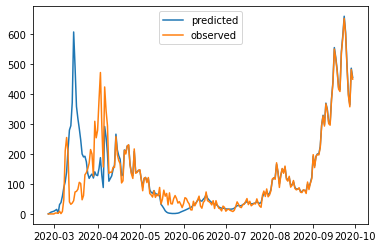

Step: 2505, Time: 0.1549844741821289, Loss: 6068.26953125, Mean Expected Daily Hospit: 132.19412231445312
Step: 2510, Time: 0.1546320915222168, Loss: 6038.20947265625, Mean Expected Daily Hospit: 133.22222900390625
Step: 2515, Time: 0.2567617893218994, Loss: 6017.95361328125, Mean Expected Daily Hospit: 133.9331512451172
Step: 2520, Time: 0.19857335090637207, Loss: 5997.03466796875, Mean Expected Daily Hospit: 133.9786376953125
Step: 2525, Time: 0.15414738655090332, Loss: 5974.685546875, Mean Expected Daily Hospit: 133.67538452148438
Step: 2530, Time: 0.15141701698303223, Loss: 5953.54345703125, Mean Expected Daily Hospit: 133.35418701171875


KeyboardInterrupt: 

In [32]:
epochs = 10000

params_to_be_optimized = method.get_parameters()

optimizer = optim.Adam(params_to_be_optimized, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  expected = epid_model(population, R=method.calculate_R(), initial_newly_infected=np.arange(1, 18, 3), alpha=alpha, device=device, dtype=dtype)['newly_infected']

  # calc loss
  comparison_loss = calc_mse(expected, observed)
  method_loss = method.calculate_loss()
  loss = comparison_loss + method_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

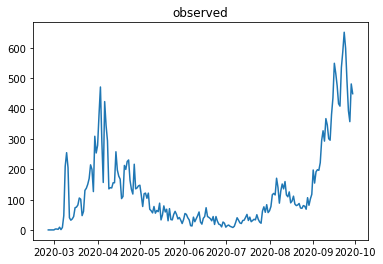

In [ ]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
plt.legend()
plt.show()